## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Prepare dataset

In [2]:
result_dir = './save_results/exercise'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)

2000


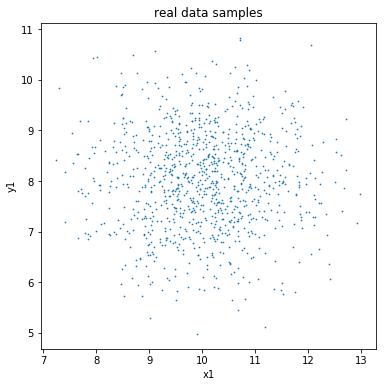

In [3]:
def sample_real(batch_size = 100):
    x = torch.randn(batch_size, 2) # x ~ N(mu=0, std=1)
    x[:, 0] += 10
    x[:, 1] += 8
    return x

plt.figure(figsize=(6,6))
x = sample_real(1000).numpy()
print(x.size)

plt.scatter(x[:, 0], x[:, 1], 0.5)
plt.title('real data samples')
plt.xlabel('x1')
plt.ylabel('y1')
plt.show()

## 3. Build Model
### 3.1 Encoder

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.linear1 = nn.Sequential(
            nn.Linear(2, 8),
            nn.ELU()
        )
        self.linear_mu = nn.Linear(8, 8)
        self.linear_sigma = nn.Linear(8, 8)
        self._init_parameters()
        
    def forward(self, inputs):
        output = self.linear1(inputs)
        mu = self.linear_mu(output)
        sigma = self.linear_sigma(output)
        eps = torch.randn(mu.size())
        
        if USE_CUDA:
            eps = eps.cuda()
        
        z = mu + sigma * eps
        
        return z, mu, sigma
        
    def _init_parameters(self):
        for p in self.parameters():
            if p.ndimension() > 1:
                init.kaiming_normal(p)

### 3.2 Decoder

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Sequential(
            nn.Linear(8, 8),
            nn.ELU()
        )
        self.linear2 = nn.Linear(8, 2)
        self._init_parameters()
        
    def forward(self, inputs):
        output = self.linear1(inputs)
        output = self.linear2(output)
        return output
        
    def _init_parameters(self):
        for p in self.parameters():
            if p.ndimension() > 1:
                init.kaiming_normal(p)

In [6]:
encoder = Encoder()
decoder = Decoder()

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


### Utils

In [7]:
def plot_decoder(epoch, batch_size = 200, save_image=False):
    
    plt.figure(figsize=(5,5))
    z = torch.randn(batch_size, 8)
    
    if USE_CUDA:
        z = z.cuda()
    
    x_gen = decoder(z).cpu().data.numpy()
    plt.scatter(x_gen[:, 0], x_gen[:, 1], 0.8)
    
    x_real = sample_real(200).numpy()
    plt.scatter(x_real[:, 0], x_real[:, 1], 0.8)
    plt.legend(['VAE', 'Real Data'])
    plt.title("epoch : {}".format(epoch))
    plt.xlim([-1, 11])
    plt.ylim([-1, 11])
    
    if save_image:
        plt.savefig(result_dir + '/VAE_2d_sample_{}.png'.format(epoch))
    
    return x_gen.mean(0), x_gen.std(0)

## 4. Loss Func & Optims
$$E_{z~Q}[log_P X|z] + D_{KL}[Q(z|x)\| P(z)]$$
- loss = reconstruction loss + latent loss
- reconstruction loss = X_generated should equal X 
    - MSE, Regression, etc..
- latent loss = drive $\mu$ and $\Sigma$ toward an Isotropic Gaussian => $\mu^2 + tr \Sigma$

In [8]:
def loss_function(x_gen, x, mu, std):
        reconstruction_loss = torch.mean((x_gen - x)**2)
        D_kl = 0.5 * torch.mean(mu**2 + std**2 - 1 - 2 * torch.log(1e-10 + torch.abs(std)))
        loss = reconstruction_loss + D_kl
        return loss

from itertools import chain

lr = 0.001
max_epoch = 30000
batch_size = 200

parameters = chain(encoder.parameters(), decoder.parameters())
optimizer = optim.Adam(parameters, lr=lr)

## 5. Train

[0/30000] loss : 850.21338


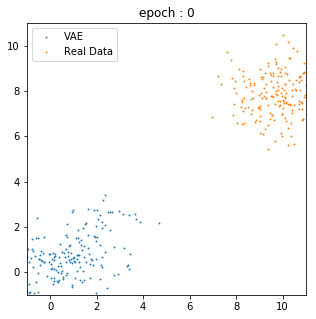

mean = [-0.44961244 -0.60866565], std= [2.240763  2.1096406]
[1000/30000] loss : 6.53816
[2000/30000] loss : 5.06599
[3000/30000] loss : 3.47520
[4000/30000] loss : 2.49842
[5000/30000] loss : 1.66175


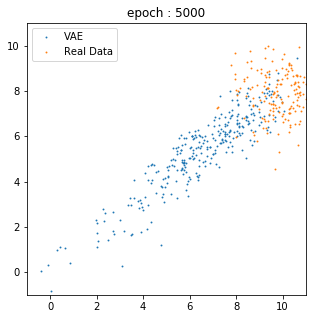

mean = [6.4798546 5.3292603], std= [2.1486425 1.8206749]
[6000/30000] loss : 1.64792
[7000/30000] loss : 2.01121
[8000/30000] loss : 1.96379
[9000/30000] loss : 1.62617
[10000/30000] loss : 1.39283


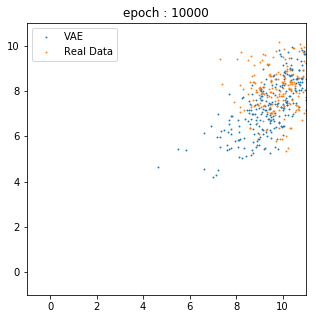

mean = [9.647241  7.5964565], std= [1.2174793 1.4114089]
[11000/30000] loss : 2.30141
[12000/30000] loss : 1.15664
[13000/30000] loss : 0.95864
[14000/30000] loss : 0.82867
[15000/30000] loss : 1.05085


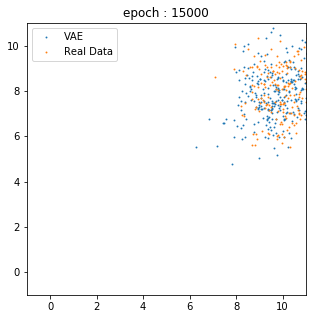

mean = [9.871074  7.9411907], std= [1.0937685 1.168819 ]
[16000/30000] loss : 1.00536
[17000/30000] loss : 0.84325
[18000/30000] loss : 1.95238
[19000/30000] loss : 2.01344
[20000/30000] loss : 1.54074


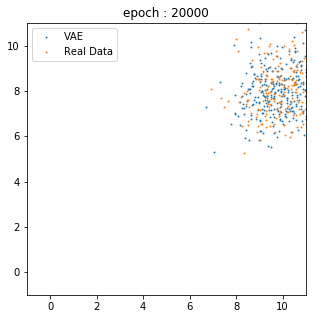

mean = [9.890048  7.9557586], std= [1.025629  1.0108786]
[21000/30000] loss : 1.25896
[22000/30000] loss : 1.16745
[23000/30000] loss : 0.86153
[24000/30000] loss : 0.75150
[25000/30000] loss : 1.78797


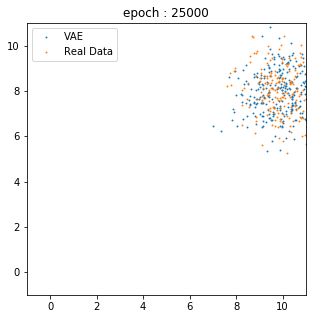

mean = [9.976586 7.986547], std= [0.96151143 0.98222727]
[26000/30000] loss : 1.27187
[27000/30000] loss : 1.07094
[28000/30000] loss : 0.77248
[29000/30000] loss : 0.72825
[30000/30000] loss : 1.20725


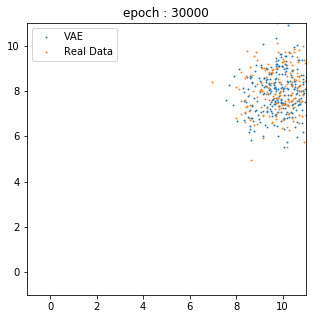

mean = [10.024002   7.9268694], std= [0.9269194  0.97076774]


In [9]:
for epoch in range(max_epoch + 1):
    optimizer.zero_grad() # Zero Gradient Container
    
    x = Variable(sample_real(batch_size))
    
    if USE_CUDA:
        x = x.cuda()
    
    z, mu, std = encoder(x)
    x_gen = decoder(z)
    
    loss = loss_function(x_gen, x, mu, std)
    
    loss.backward() # Compute gradient
    optimizer.step() # gradient update
    
    if epoch % 1000 == 0:
        print("[%d/%d] loss : %0.5f"%(epoch, max_epoch, loss.item()))
        
    if epoch % 5000 == 0:
        mean, std = plot_decoder(epoch, batch_size=300, save_image=True)
        plt.show()
        print("mean = {}, std= {}".format(mean, std))

## 6. Display Results

In [10]:
import imageio

images = []
for epoch in range(max_epoch + 1):
    try:
        img_name = result_dir + '/VAE_2d_sample_{}.png'.format(epoch)
        images.append(imageio.imread(img_name))
    except:
        pass

imageio.mimsave(result_dir + '/VAE_2d_sample_total.gif', images, fps=3)

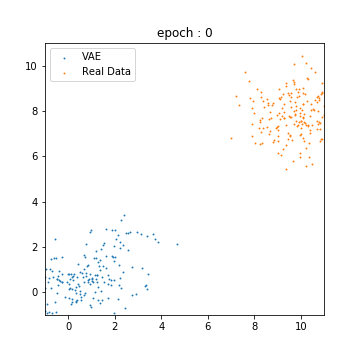

In [11]:
from IPython.display import Image

with open(result_dir + '/VAE_2d_sample_total.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))